<a href="https://colab.research.google.com/github/Shashank1202/Deep_Learning/blob/main/VAEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as k
from scipy.stats import norm
from tensorflow.keras import (
    layers,
    datasets,
    models,
    callbacks,
    losses,
    optimizers,
    metrics
)

In [2]:
def sample_batch(dataset):
  batch= dataset.take(1).get_single_element()
  if isinstance(batch, tuple):
    batch= batch[0]
  return batch.empty()

In [3]:
def display_images(images, number_images_to_display= 10, size=(20, 3), cmap="gray_r", as_type="float32"):
  if images.max()>1.0:
    images= images/255.0
  elif images.min()< 0.0:
    images= (images+1.0)/2.0

  plt.figure(figsize=size)

  for i in range(number_images_to_display):
    x1= plt.subplot(1, number_images_to_display, i+1)
    plt.imshow(images[i].astype(as_type), cmap= cmap)
    plt.axis("off")

  plt.show()

In [4]:
(x_train, y_train), (x_test, y_test)= datasets.fashion_mnist.load_data()

In [5]:
def preprocessing_images(images):
  images= images.astype("float32")/255.0
  images= np.pad(images, ((0,0), (2,2), (2,2)), constant_values=0.0)
  images= np.expand_dims(images, -1)
  return images

In [6]:
x_train=preprocessing_images(x_train)
x_test=preprocessing_images(x_test)

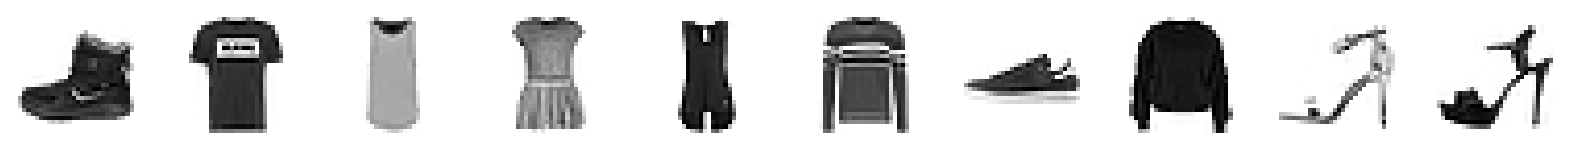

In [7]:
display_images(x_train)

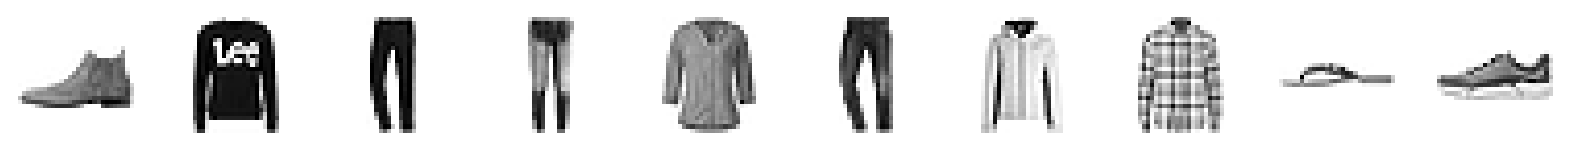

In [8]:
display_images(x_test)

In [9]:
class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var= inputs
    batch= tf.shape(z_mean)[0]
    dim= tf.shape(z_mean)[1]
    epsilon= k.random_normal(shape= (batch, dim))
    return z_mean+ tf.exp(0.5 * z_log_var) * epsilon

In [10]:
image_size= 32
embed_dim= 2

#LETS DESING THE ENCODER PART

encoder_input= layers.Input(
    shape=(image_size, image_size, 1), name= "encoder_input"
)

x= layers.Conv2D(32, (3,3), strides=2, activation="relu", padding="same")(encoder_input)
x= layers.Conv2D(64, (3,3), strides=2, activation="relu", padding="same")(x)
x= layers.Conv2D(128, (3,3), strides=2, activation="relu", padding="same")(x)

shape_before_flattening= k.int_shape(x)[1:] #Decoder will need this

x=layers.Flatten()(x)

z_mean= layers.Dense(embed_dim, name="z_mean_layer")(x)
z_log_var= layers.Dense(embed_dim, name="z_log_var_layer")(x)


z=Sampling()([z_mean, z_log_var])

encoder= models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

In [11]:
#Decoder

decoder_input= layers.Input(shape=(embed_dim), name="decoder_input_layer")

x= layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x= layers.Reshape(shape_before_flattening)(x)
x= layers.Conv2DTranspose(128, (3,3), strides=2, activation="relu", padding="same")(x)
x= layers.Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same")(x)
x= layers.Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(x)

decoder_output= layers.Conv2D(
    1, (3, 3), strides=1, activation= "sigmoid", padding="same", name="decoder_output_layer"
)(x)

decoder= models.Model(decoder_input, decoder_output)
decoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input_layer (Input  [(None, 2)]               0         
 Layer)                                                          
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                             

In [12]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property  # Use property decorator
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            beta = 500
            reconstruction_loss = tf.reduce_mean(
                beta * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)

        beta = 500
        reconstruction_loss = tf.reduce_mean(
            beta * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss
        }


In [13]:
vae= VAE(encoder, decoder)

In [14]:
#Training

optimizer= optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer= optimizer)

In [15]:
model_checkpoint_callback= callbacks.ModelCheckpoint(
    filepath= "./checkpoint",
    save_weights_only= False,
    save_freq= "epoch",
    monitor= "loss",
    mode= "min",
    save_best_only= True,
    verboss= 0
)

In [16]:
vae.fit(
    x_train,
    epochs= 20,
    batch_size=64,
    shuffle=True,
    validation_data= (x_test, x_test),
    callbacks= [model_checkpoint_callback]
)

Epoch 1/20
938/938 [==============================] - ETA: 0s - total_loss: 196.1984 - reconstruction_loss: 196.1383 - kl_loss: 0.0600

938/938 [==============================] - 27s 18ms/step - total_loss: 196.1984 - reconstruction_loss: 196.1383 - kl_loss: 0.0600 - val_loss: 178.1279 - val_reconstruction_loss: 178.1263 - val_kl_loss: 0.0016
Epoch 2/20
935/938 [============================>.] - ETA: 0s - total_loss: 187.9797 - reconstruction_loss: 187.9702 - kl_loss: 0.0094

938/938 [==============================] - 8s 9ms/step - total_loss: 187.9827 - reconstruction_loss: 187.9731 - kl_loss: 0.0095 - val_loss: 176.3139 - val_reconstruction_loss: 176.3071 - val_kl_loss: 0.0068
Epoch 3/20
934/938 [============================>.] - ETA: 0s - total_loss: 187.9177 - reconstruction_loss: 187.9049 - kl_loss: 0.0127

938/938 [==============================] - 7s 8ms/step - total_loss: 187.9054 - reconstruction_loss: 187.8926 - kl_loss: 0.0127 - val_loss: 177.8710 - val_reconstruction_loss: 177.8687 - val_kl_loss: 0.0022
Epoch 4/20
938/938 [==============================] - ETA: 0s - total_loss: 187.8914 - reconstruction_loss: 187.8804 - kl_loss: 0.0110

938/938 [==============================] - 8s 9ms/step - total_loss: 187.8914 - reconstruction_loss: 187.8804 - kl_loss: 0.0110 - val_loss: 177.2065 - val_reconstruction_loss: 177.2064 - val_kl_loss: 1.5038e-04
Epoch 5/20
936/938 [============================>.] - ETA: 0s - total_loss: 187.8486 - reconstruction_loss: 187.8442 - kl_loss: 0.0045

938/938 [==============================] - 8s 9ms/step - total_loss: 187.8450 - reconstruction_loss: 187.8407 - kl_loss: 0.0045 - val_loss: 176.8257 - val_reconstruction_loss: 176.8252 - val_kl_loss: 4.9528e-04
Epoch 6/20
937/938 [============================>.] - ETA: 0s - total_loss: 187.8453 - reconstruction_loss: 187.8397 - kl_loss: 0.0054

938/938 [==============================] - 7s 8ms/step - total_loss: 187.8542 - reconstruction_loss: 187.8486 - kl_loss: 0.0054 - val_loss: 176.9137 - val_reconstruction_loss: 176.9134 - val_kl_loss: 2.5329e-04
Epoch 7/20
937/938 [============================>.] - ETA: 0s - total_loss: 187.8363 - reconstruction_loss: 187.8315 - kl_loss: 0.0048

938/938 [==============================] - 8s 9ms/step - total_loss: 187.8316 - reconstruction_loss: 187.8269 - kl_loss: 0.0048 - val_loss: 178.1205 - val_reconstruction_loss: 178.1200 - val_kl_loss: 4.5311e-04
Epoch 8/20
932/938 [============================>.] - ETA: 0s - total_loss: 187.8013 - reconstruction_loss: 187.7953 - kl_loss: 0.0058

938/938 [==============================] - 8s 9ms/step - total_loss: 187.8064 - reconstruction_loss: 187.8003 - kl_loss: 0.0059 - val_loss: 177.0933 - val_reconstruction_loss: 177.0899 - val_kl_loss: 0.0034
Epoch 9/20
938/938 [==============================] - ETA: 0s - total_loss: 187.8136 - reconstruction_loss: 187.8052 - kl_loss: 0.0083

938/938 [==============================] - 7s 8ms/step - total_loss: 187.8136 - reconstruction_loss: 187.8052 - kl_loss: 0.0083 - val_loss: 176.1372 - val_reconstruction_loss: 176.1370 - val_kl_loss: 1.4794e-04
Epoch 10/20
934/938 [============================>.] - ETA: 0s - total_loss: 187.7956 - reconstruction_loss: 187.7929 - kl_loss: 0.0026

938/938 [==============================] - 8s 9ms/step - total_loss: 187.7953 - reconstruction_loss: 187.7926 - kl_loss: 0.0026 - val_loss: 177.9351 - val_reconstruction_loss: 177.9345 - val_kl_loss: 6.6274e-04
Epoch 11/20
938/938 [==============================] - ETA: 0s - total_loss: 187.7977 - reconstruction_loss: 187.7965 - kl_loss: 0.0012

938/938 [==============================] - 9s 10ms/step - total_loss: 187.7977 - reconstruction_loss: 187.7965 - kl_loss: 0.0012 - val_loss: 176.9240 - val_reconstruction_loss: 176.9227 - val_kl_loss: 0.0013
Epoch 12/20
937/938 [============================>.] - ETA: 0s - total_loss: 187.7954 - reconstruction_loss: 187.7921 - kl_loss: 0.0036

938/938 [==============================] - 8s 8ms/step - total_loss: 187.7957 - reconstruction_loss: 187.7924 - kl_loss: 0.0036 - val_loss: 177.8787 - val_reconstruction_loss: 177.8780 - val_kl_loss: 7.5173e-04
Epoch 13/20
934/938 [============================>.] - ETA: 0s - total_loss: 187.7985 - reconstruction_loss: 187.7943 - kl_loss: 0.0043

938/938 [==============================] - 9s 9ms/step - total_loss: 187.7939 - reconstruction_loss: 187.7897 - kl_loss: 0.0043 - val_loss: 176.5219 - val_reconstruction_loss: 176.5213 - val_kl_loss: 6.4373e-04
Epoch 14/20
935/938 [============================>.] - ETA: 0s - total_loss: 187.7645 - reconstruction_loss: 187.7618 - kl_loss: 0.0026

938/938 [==============================] - 9s 10ms/step - total_loss: 187.7577 - reconstruction_loss: 187.7551 - kl_loss: 0.0026 - val_loss: 177.3152 - val_reconstruction_loss: 177.3147 - val_kl_loss: 5.1901e-04
Epoch 15/20
934/938 [============================>.] - ETA: 0s - total_loss: 187.7641 - reconstruction_loss: 187.7623 - kl_loss: 0.0017

938/938 [==============================] - 8s 8ms/step - total_loss: 187.7745 - reconstruction_loss: 187.7727 - kl_loss: 0.0017 - val_loss: 178.4978 - val_reconstruction_loss: 178.4970 - val_kl_loss: 7.8455e-04
Epoch 16/20
934/938 [============================>.] - ETA: 0s - total_loss: 187.7742 - reconstruction_loss: 187.7705 - kl_loss: 0.0038

938/938 [==============================] - 8s 9ms/step - total_loss: 187.7643 - reconstruction_loss: 187.7606 - kl_loss: 0.0038 - val_loss: 177.6358 - val_reconstruction_loss: 177.6348 - val_kl_loss: 0.0010
Epoch 17/20
935/938 [============================>.] - ETA: 0s - total_loss: 187.7478 - reconstruction_loss: 187.7446 - kl_loss: 0.0031

938/938 [==============================] - 8s 9ms/step - total_loss: 187.7511 - reconstruction_loss: 187.7478 - kl_loss: 0.0032 - val_loss: 178.5918 - val_reconstruction_loss: 178.5908 - val_kl_loss: 0.0010
Epoch 18/20
933/938 [============================>.] - ETA: 0s - total_loss: 187.7551 - reconstruction_loss: 187.7531 - kl_loss: 0.0020

938/938 [==============================] - 8s 8ms/step - total_loss: 187.7554 - reconstruction_loss: 187.7533 - kl_loss: 0.0020 - val_loss: 177.3818 - val_reconstruction_loss: 177.3794 - val_kl_loss: 0.0024
Epoch 19/20
937/938 [============================>.] - ETA: 0s - total_loss: 187.7480 - reconstruction_loss: 187.7448 - kl_loss: 0.0030

938/938 [==============================] - 8s 9ms/step - total_loss: 187.7567 - reconstruction_loss: 187.7536 - kl_loss: 0.0030 - val_loss: 177.3109 - val_reconstruction_loss: 177.3104 - val_kl_loss: 4.7106e-04
Epoch 20/20
937/938 [============================>.] - ETA: 0s - total_loss: 187.7472 - reconstruction_loss: 187.7452 - kl_loss: 0.0021

938/938 [==============================] - 8s 9ms/step - total_loss: 187.7473 - reconstruction_loss: 187.7453 - kl_loss: 0.0021 - val_loss: 177.5642 - val_reconstruction_loss: 177.5634 - val_kl_loss: 7.8529e-04


In [17]:
#Save the Trained chechpoints

vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

In [18]:
#Lets Reconstruct using our Trained VAE

number_images_to_predict= 5000
example_images= x_test[:number_images_to_predict]
example_labels= y_test[:number_images_to_predict]

In [19]:
z_mean, z_log_var, reconstruction= vae.predict(example_images)

157/157 [==============================] - 1s 4ms/step


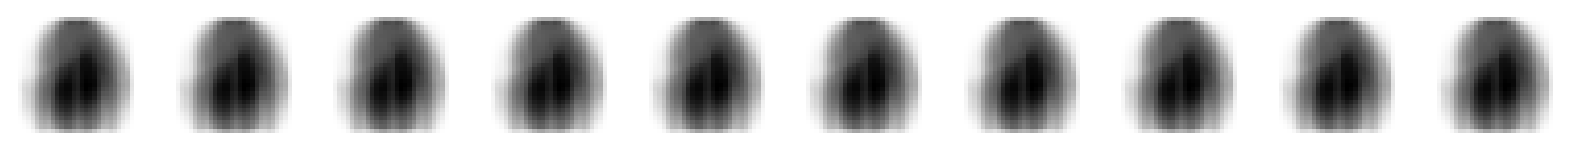

In [20]:
display_images(reconstruction)

In [21]:
#visualize latent space

z_mean, z_var, z= encoder.predict(example_images)
p=norm.cdf(z)

157/157 [==============================] - 0s 2ms/step


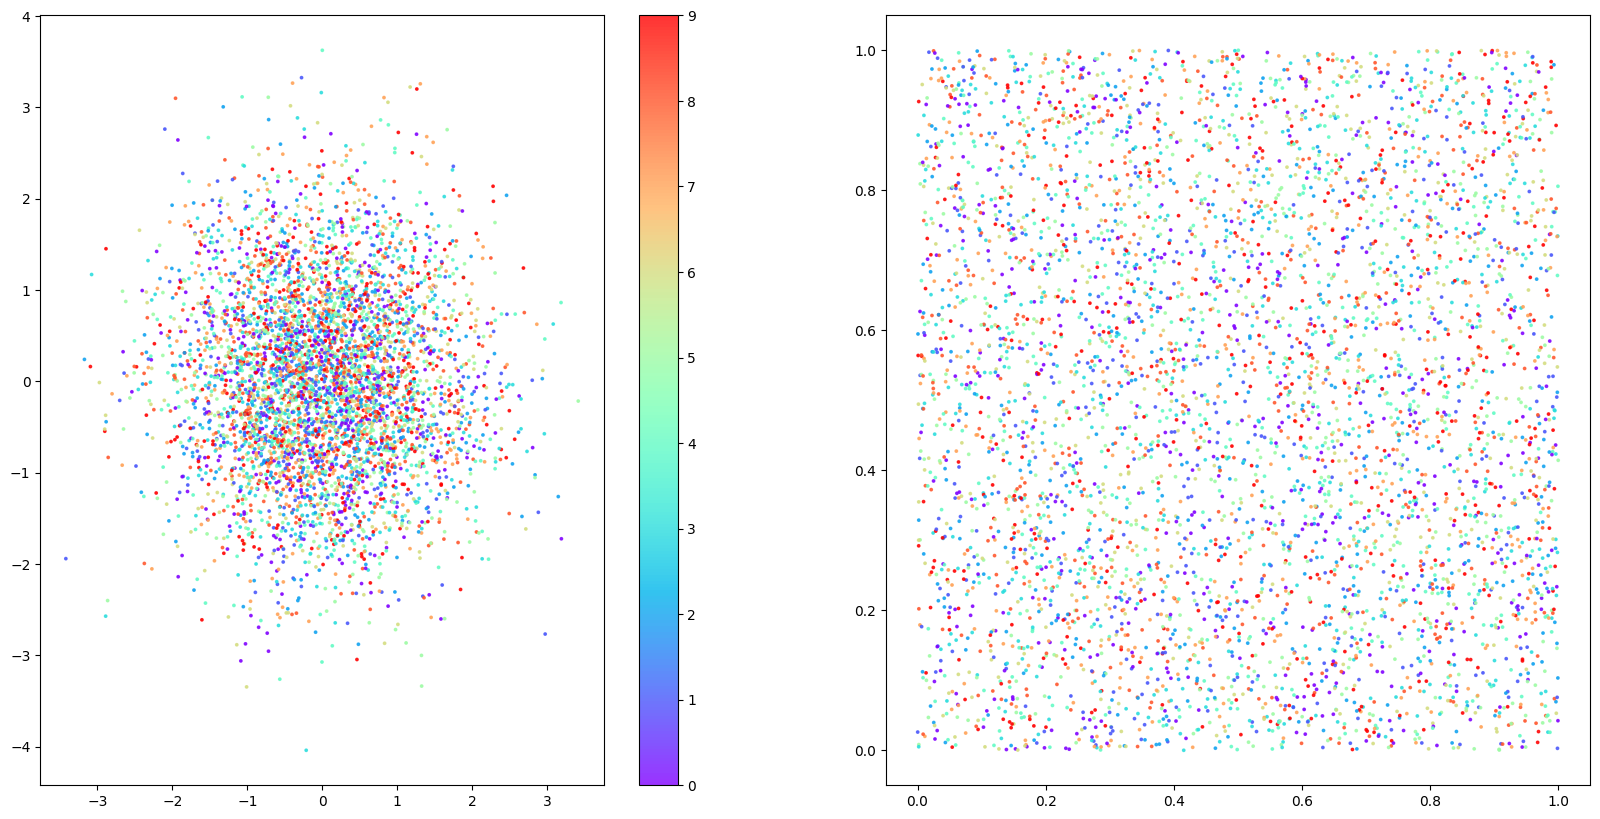

In [22]:
figsize= 10
fig= plt.figure(figsize=(figsize*2, figsize))
ax= fig.add_subplot(1,2,1)
plot_1= ax.scatter(
    z[:, 0], z[:, 1],cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)

ax= fig.add_subplot(1, 2, 2)
plot_2= ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c= example_labels, alpha=0.8, s=3

)
plt.show()